In [1]:
import sys
import os

# Check if the notebook is running in Google Colab
def in_colab():
    return 'google.colab' in sys.modules

# If in Colab, create the directory structure and download the required files
if in_colab():
    os.makedirs('graph_gen', exist_ok=True)
    !wget -q https://raw.githubusercontent.com/jojohannsen/langgraph_gen/main/graph_gen/gen_graph.py -O graph_gen/gen_graph.py
    !wget -q https://raw.githubusercontent.com/jojohannsen/langgraph_gen/main/graph_gen/__init__.py -O graph_gen/__init__.py

In [2]:
from graph_gen.gen_graph import gen_graph

# How to use Pydantic model as state

Every [StateGraph](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.StateGraph) is a state machine. When initializing, it accepts a `state_schema` that tells it the "shape" of its state and how to incorporate updates from the nodes into a shared representation of what work has been done.

The `state_schema` can be any [type](https://docs.python.org/3/library/stdtypes.html#type-objects), though we typically use a python-native `TypedDict` in our examples (or in the case of [MessageGraph](https://langchain-ai.github.io/langgraph/reference/graphs/#messagegraph), a [list](https://docs.python.org/3/library/stdtypes.html#list)).

If you want to apply additional validation on state updates, you could instead opt for a pydantic [BaseModel](https://docs.pydantic.dev/latest/api/base_model/).

In this example, we will create a ReAct agent using a pydantic base model as the state object. This means all nodes receive an instance of the model as their first arg, and validation is run before each node executes.

## Setup

First we need to install the packages required

In [2]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai

Next, we need to set API keys for OpenAI (the LLM we will use) and Tavily (the search tool we will use)

In [3]:
import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

Optionally, we can set API key for [LangSmith tracing](https://smith.langchain.com/), which will give us best-in-class observability.

In [4]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
_set_env("LANGCHAIN_API_KEY")

## Set up the tools

We will first define the tools we want to use.
For this simple example, we will use create a placeholder search engine.
However, it is really easy to create your own tools - see documentation [here](https://python.langchain.com/v0.2/docs/how_to/custom_tools) on how to do that.


In [5]:
from langchain_core.tools import tool

@tool
def search(query: str):
    """Call to surf the web."""
    # This is a placeholder for the actual implementation
    # Don't let the LLM know this though 😊
    return ["95 degrees."]

tools = [search]

We can now wrap these tools in a simple [ToolExecutor](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolexecutor).
This is a real simple class that takes in a [ToolInvocation](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolinvocation) and calls that tool, returning the output.

A ToolInvocation is any dict-like class with `tool` and `tool_input` attributes.

In [6]:
from langgraph.prebuilt import ToolExecutor

tool_executor = ToolExecutor(tools)

## Set up the model

Now we need to load the chat model we want to use.
Importantly, this should satisfy two criteria:

1. It should work with messages. We will represent all agent state in the form of messages, so it needs to be able to work well with them.
2. It should work with OpenAI function calling. This means it should either be an OpenAI model or a model that exposes a similar interface.

Note: these model requirements are not requirements for using LangGraph - they are just requirements for this one example.


In [7]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(temperature=0)


After we've done this, we should make sure the model knows that it has these tools available to call.
We can do this by converting the LangChain tools into the format for OpenAI function calling, and then bind them to the model class.


In [8]:
model = model.bind_tools(tools)

## Define the agent state

The main type of graph in `langgraph` is the [StateGraph](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.StateGraph).
This graph is parameterized by a state object that it passes around to each node.
Each node then returns operations to update that state.
These operations can either SET specific attributes on the state (e.g. overwrite the existing values) or ADD to the existing attribute.
Whether to set or add is denoted by annotating the state object you construct the graph with.

For this example, the state we will track will just be a list of messages.
We want each node to just add messages to that list.
Therefore, we will use a `pydantic.BaseModel` with one key (`messages`) and annotate it so that the `messages` attribute is treated as "append-only".


In [9]:
import operator
from typing import Annotated, Sequence

from langchain_core.messages import BaseMessage
from langchain_core.pydantic_v1 import BaseModel


class AgentState(BaseModel):
    messages: Annotated[Sequence[BaseMessage], operator.add]

## Define the nodes

We now need to define a few different nodes in our graph.
In `langgraph`, a node can be either a function or a [runnable](https://python.langchain.com/v0.2/docs/concepts/#langchain-expression-language-lcel).
There are two main nodes we need for this:

1. The agent: responsible for deciding what (if any) actions to take.
2. A function to invoke tools: if the agent decides to take an action, this node will then execute that action.

We will also need to define some edges.
Some of these edges may be conditional.
The reason they are conditional is that based on the output of a node, one of several paths may be taken.
The path that is taken is not known until that node is run (the LLM decides).

1. Conditional Edge: after the agent is called, we should either:
   a. If the agent said to take an action, then the function to invoke tools should be called
   b. If the agent said that it was finished, then it should finish
2. Normal Edge: after the tools are invoked, it should always go back to the agent to decide what to do next

Let's define the nodes, as well as a function to decide how what conditional edge to take.

**MODIFICATION**

We define each node to receive the AgentState base model as its first argument.

In [10]:
from langchain_core.messages import ToolMessage

from langgraph.prebuilt import ToolInvocation


# Define the function that calls the model
def call_model(state):
    messages = state.messages
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define the function to execute tools
def call_tool(state):
    messages = state.messages
    # Based on the continue condition
    # we know the last message involves a function call
    last_message = messages[-1]
    # We construct an ToolInvocation from the function_call
    tool_call = last_message.tool_calls[0]
    action = ToolInvocation(
        tool=tool_call["name"],
        tool_input=tool_call["args"],
    )
    # We call the tool_executor and get back a response
    response = tool_executor.invoke(action)
    # We use the response to create a ToolMessage
    tool_message = ToolMessage(
        content=str(response), name=action.tool, tool_call_id=tool_call["id"]
    )
    # We return a list, because this will get added to the existing list
    return {"messages": [tool_message]}

## Define the graph

We can now put it all together and define the graph!

In [11]:
from langgraph.graph import END, StateGraph, START

def no_tools(state):
    return not state.messages[-1].tool_calls
    
graph_spec = """

call_model(AgentState)
  no_tools => END
  => call_tool

call_tool
  => call_model
  
"""

graph_code = gen_graph("state_model", graph_spec)
#print(graph_code)
exec(graph_code)

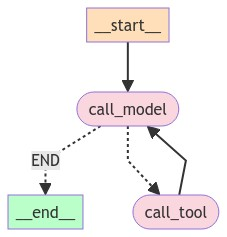

In [12]:
from IPython.display import Image, display

display(Image(state_model.get_graph().draw_mermaid_png()))

## Use it!

We can now use it!
This now exposes the [same interface](https://python.langchain.com/v0.2/docs/concepts/#langchain-expression-language-lcel) as all other LangChain runnables.

In [13]:
from langchain_core.messages import HumanMessage

inputs = {"messages": [HumanMessage(content="what is the weather in sf")]}
for chunk in state_model.stream(inputs, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

what is the weather in sf
================================== Ai Message ==================================
Tool Calls:
  search (call_38i074IPCbM699K7ubMieup9)
 Call ID: call_38i074IPCbM699K7ubMieup9
  Args:
    query: weather in San Francisco
================================= Tool Message =================================
Name: search

['95 degrees.']
================================== Ai Message ==================================

The weather in San Francisco is currently 95 degrees.
